In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import os

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
# Install pyspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=4e8142bb441dbbeb3d10ce23e21a5f7cd953805346f0cd72bac35082db109916
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StringType


# 1) Create a SparkSession
spark = SparkSession.builder.appName("CSVtoCHUNK").config("spark.driver.memory", "16g").getOrCreate()

# 2) spark dataframe
df_email_spark = None

folder_path = '/content/gdrive/MyDrive/processati_email'

i=0

for filename in os.listdir(folder_path):

    if filename.startswith('email_') and filename.endswith('.csv'):
        i=i+1
        file_path = os.path.join(folder_path, filename)

        #if i ==2: break

        #read the CSV files into temporary Spark DataFrames (temp_df),
        # and append them to df_email_spark using the union method
        temp_df = spark.read.csv(file_path, header=True, inferSchema=True)

        if df_email_spark is None:
            df_email_spark = temp_df
            print(i , ' FILE caricato:', filename)# , ', righe:', df_email_spark.count())
        else:
            df_email_spark = df_email_spark.union(temp_df)
            print(i , ' FILE caricato:', filename)# , ':', df_email_spark.count())


#df_email_spark.show()
#print('dataset completo: ', df_email_spark.count())


1  FILE caricato: email_60-79.csv
2  FILE caricato: email_0-19.csv
3  FILE caricato: email_20-39.csv
4  FILE caricato: email_80-99.csv
5  FILE caricato: email_40-59.csv
6  FILE caricato: email_100-119.csv
7  FILE caricato: email_120-139.csv
8  FILE caricato: email_180-199.csv
9  FILE caricato: email_160-179.csv
10  FILE caricato: email_140-159.csv
11  FILE caricato: email_220-239.csv
12  FILE caricato: email_240-259.csv
13  FILE caricato: email_200-219.csv
14  FILE caricato: email_260-279.csv
15  FILE caricato: email_280-299.csv
16  FILE caricato: email_300-319.csv
17  FILE caricato: email_340-359.csv
18  FILE caricato: email_360-379.csv
19  FILE caricato: email_320-339.csv
20  FILE caricato: email_400-419.csv
21  FILE caricato: email_380-399.csv
22  FILE caricato: email_440-459.csv
23  FILE caricato: email_420-439.csv
24  FILE caricato: email_480-500.csv
25  FILE caricato: email_460-479.csv


In [ ]:

# Replace null values with "null" so that I can see it on the print
df_temp = df_email_spark.fillna("null", subset=["source_selector", "destination_selector"])

# Pivot table for source_service and source_selector
pivot_source = df_temp.groupBy("source_service", "source_selector").agg(
    F.count("message_id").alias("count_nonzero"),
    F.countDistinct("message_id").alias("nunique")
).orderBy(F.desc("nunique"))

# Pivot table for destination_service and destination_selector
pivot_destination = df_temp.groupBy("destination_service", "destination_selector").agg(
    F.count("message_id").alias("count_nonzero"),
    F.countDistinct("message_id").alias("nunique")
).orderBy(F.desc("nunique"))

# Pivot table for action_type
pivot_action_type = df_temp.groupBy("action_type").agg(
    F.count("message_id").alias("count_nonzero"),
    F.countDistinct("message_id").alias("nunique")
).orderBy(F.desc("nunique"))



################ RESULT PRINT ####################àà
print("SOURCE ORDERED:")
pivot_source.show()

print("DESTINATION ORDERED:")
pivot_destination.show()

print("La frequenza degli action_type:")
pivot_action_type.show()



SOURCE ORDERED:
+-------------------+---------------+-------------+--------+
|     source_service|source_selector|count_nonzero| nunique|
+-------------------+---------------+-------------+--------+
|       smtp-inbound|           null|     57312012|10853607|
|           gmail-ui|           send|      7818852| 2601961|
|mailing-list-server|           null|     21214698| 2325634|
|         smtp-relay| gmail-for-work|       617571|  302736|
|           smtp-msa|           null|       304861|  131468|
|             groups|      groups-ui|        28440|   12404|
|           gmail-ui|           null|            3|       2|
+-------------------+---------------+-------------+--------+

DESTINATION ORDERED:
+--------------------+--------------------+-------------+--------+
| destination_service|destination_selector|count_nonzero| nunique|
+--------------------+--------------------+-------------+--------+
|            gmail-ui|                null|     57369122|10853607|
|smtp-outbound-to-...|g

In [ ]:
# Group by "message_id" and collect the list of "destination_address"
grouped = df_email_spark.groupBy("message_id").agg(
    F.collect_list("destination_address").alias("lista_destinatari")
)

# Create a DataFrame with columns "message_id" and "lista_destinatari"
result_df_dest = grouped.select("message_id", "lista_destinatari")

# Add a column "#destinatari_per_email" with the number of recipients per email
result_df_dest = result_df_dest.withColumn(
    "#destinatari_per_email",
    F.size("lista_destinatari")
)

# Group by the number of recipients and count the number of emails
numero_dest = result_df_dest.groupBy("#destinatari_per_email").count().withColumnRenamed("count", "num_of_email_con_#destinatari")
numero_dest_sorted = numero_dest.orderBy(F.desc("num_of_email_con_#destinatari"))

#numero_dest_sorted.show(800)

sum_of_emails_above_25 = numero_dest_sorted.filter(numero_dest_sorted["#destinatari_per_email"] > 25).agg(F.sum("num_of_email_con_#destinatari")).collect()[0][0]

#print("Sum of num_of_email_con_#destinatari when #destinatari_per_email > 25:", sum_of_emails_above_25)



Minimo: 1
25° percentile: 2.0
Mediana (50° percentile): 3.0
75° percentile: 6.0
Massimo: 9643
Intervallo interquartile (IQR): 4.0


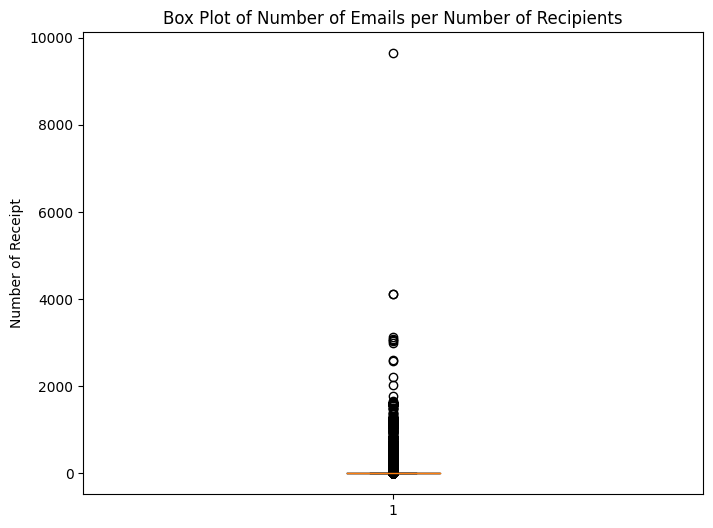

In [ ]:

# percentiles
percentile_25 = result_df_dest.approxQuantile("#destinatari_per_email", [0.25], 0.01)[0]
percentile_50 = result_df_dest.approxQuantile("#destinatari_per_email", [0.50], 0.01)[0]
percentile_75 = result_df_dest.approxQuantile("#destinatari_per_email", [0.75], 0.01)[0]

#  minimum, maximum, and IQR
min_value = result_df_dest.select(F.min("#destinatari_per_email")).first()[0]
max_value = result_df_dest.select(F.max("#destinatari_per_email")).first()[0]
iqr = percentile_75 - percentile_25

######### PRINT
print("Minimo:", min_value)
print("25° percentile:", percentile_25)
print("Mediana (50° percentile):", percentile_50)
print("75° percentile:", percentile_75)
print("Massimo:", max_value)
print("Intervallo interquartile (IQR):", iqr)

# BOXPLOT
boxplot_data = result_df_dest.select("#destinatari_per_email").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.boxplot(boxplot_data)
plt.title("Box Plot of Number of Emails per Number of Recipients")
plt.ylabel("Number of Receipt")
plt.show()


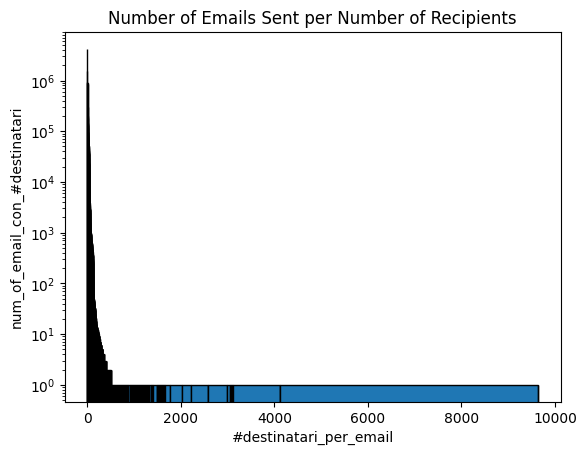

In [ ]:

# Collect(spark method) the data for plotting
hist_data = numero_dest_sorted.collect()

# Extract the data for plotting
x = [row["#destinatari_per_email"] for row in hist_data]
y = [row["num_of_email_con_#destinatari"] for row in hist_data]

# Make sure x values are unique!!
unique_x = list(set(x))
unique_x.sort()

# Specify the edges of the bins
bin_edges = unique_x + [unique_x[-1] + 1]

# Set labels and title
plt.xlabel('#destinatari_per_email')
plt.ylabel('num_of_email_con_#destinatari')
plt.title('Number of Emails Sent per Number of Recipients')

# Plot the histogram bars with adjusted heights
plt.bar(unique_x, y, align='edge', width=np.diff(bin_edges), edgecolor='black', log=True)

plt.show()


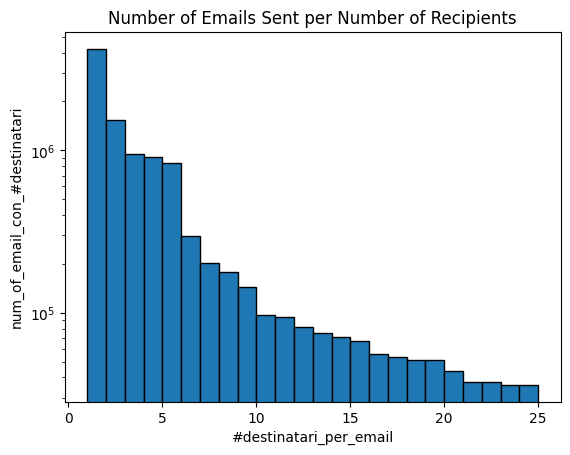

In [ ]:

numero_dest_sorted_LOCAL = numero_dest_sorted.filter(numero_dest_sorted["#destinatari_per_email"] < 25 )


# Collect the data for plotting
hist_data = numero_dest_sorted_LOCAL.collect()

# Extract the data for plotting
x = [row["#destinatari_per_email"] for row in hist_data]
y = [row["num_of_email_con_#destinatari"] for row in hist_data]

# Make sure x values are unique
unique_x = list(set(x))
unique_x.sort()

# Specify the edges of the bins
bin_edges = unique_x + [unique_x[-1] + 1]

# Set labels and title
plt.xlabel('#destinatari_per_email')
plt.ylabel('num_of_email_con_#destinatari')
plt.title('Number of Emails Sent per Number of Recipients')

# Plot the histogram bars with adjusted heights
plt.bar(unique_x, y, align='edge', width=np.diff(bin_edges), edgecolor='black', log=True)

plt.show()


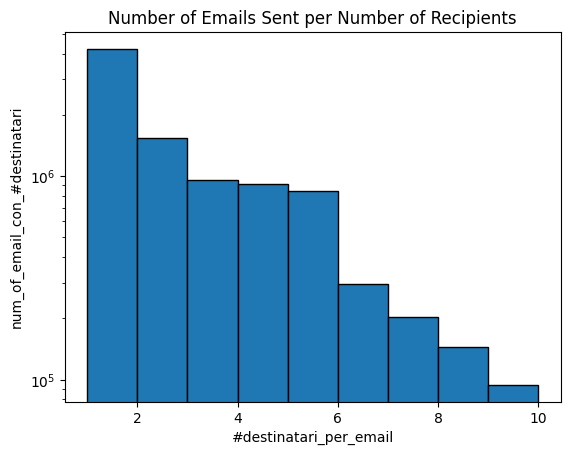

In [ ]:

numero_dest_sorted_LOCAL = numero_dest_sorted.filter(numero_dest_sorted["#destinatari_per_email"] < 10 )


# Collect the data for plotting
hist_data = numero_dest_sorted_LOCAL.collect()

# Extract the data for plotting
x = [row["#destinatari_per_email"] for row in hist_data]
y = [row["num_of_email_con_#destinatari"] for row in hist_data]

# Make sure x values are unique
unique_x = list(set(x))
unique_x.sort()

# Specify the edges of the bins
bin_edges = unique_x + [unique_x[-1] + 1]

# Set labels and title
plt.xlabel('#destinatari_per_email')
plt.ylabel('num_of_email_con_#destinatari')
plt.title('Number of Emails Sent per Number of Recipients')

# Plot the histogram bars with adjusted heights
plt.bar(unique_x, y, align='edge', width=np.diff(bin_edges), edgecolor='black', log=True)

plt.show()


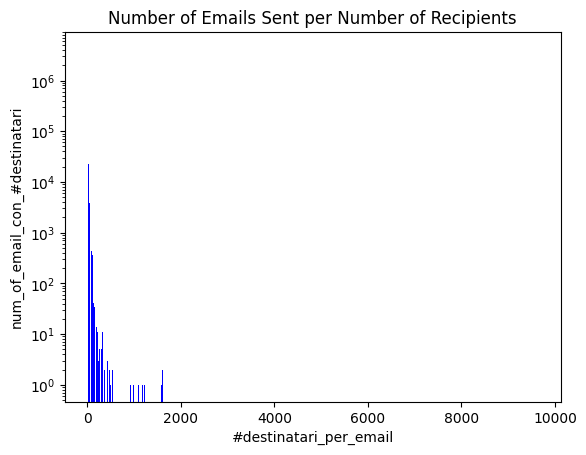

In [ ]:

# Filter data to exclude values above 100
#numero_dest_sorted_LOCAL = numero_dest_sorted.filter(numero_dest_sorted["#destinatari_per_email"] < 100)

# Collect the data for plotting
x = numero_dest_sorted.select("#destinatari_per_email").rdd.flatMap(lambda x: x).collect()
y = numero_dest_sorted.select("num_of_email_con_#destinatari").rdd.flatMap(lambda x: x).collect()

# Create the bar plot
plt.bar(x, y, align='center', color='blue')

# Set labels and title
plt.xlabel('#destinatari_per_email')
plt.ylabel('num_of_email_con_#destinatari')
plt.title('Number of Emails Sent per Number of Recipients')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Display the plot
plt.show()


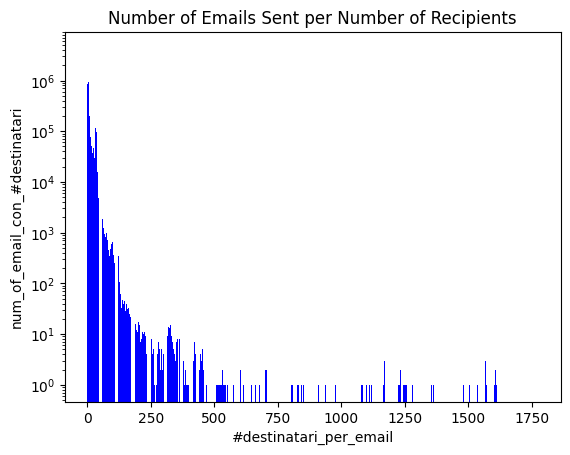

In [ ]:

# Filter data to exclude values above 100
numero_dest_sorted_LOCAL = numero_dest_sorted.filter(numero_dest_sorted["#destinatari_per_email"] < 2000)

# Collect the data for plotting
x = numero_dest_sorted_LOCAL.select("#destinatari_per_email").rdd.flatMap(lambda x: x).collect()
y = numero_dest_sorted_LOCAL.select("num_of_email_con_#destinatari").rdd.flatMap(lambda x: x).collect()

# Create the bar plot
plt.bar(x, y, align='center', color='blue')

# Set labels and title
plt.xlabel('#destinatari_per_email')
plt.ylabel('num_of_email_con_#destinatari')
plt.title('Number of Emails Sent per Number of Recipients')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Display the plot
plt.show()


In [ ]:
# Filter the DataFrame to get message IDs with #destinatari_per_email > 10
message_ids_above_10_df = result_df_dest.filter(result_df_dest["#destinatari_per_email"] > 10)

# Collect the message IDs as a list
message_ids_list = message_ids_above_10_df.select("message_id").rdd.flatMap(lambda x: x).collect()

# Print the list of message IDs
print(message_ids_list)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(message_ids_list[1:10])


['<!&!AAAAAAAAAAAYAAAAAAAAAD13KJ1RzGRKoG+5RhWFyjXCgAAAEAAAAECZWW+WhulGn8dMH2p1+MABAAAAAA==@notaiopantani.it>', '<!&!AAAAAAAAAAAYAAAAAAAAAD24IbwHVSlApxo6WAf7f/1C3wAAEAAAAL4vcex+2oxIo+zPkV/yHUIBAAAAAA==@ondapacksud.it>', '<!&!AAAAAAAAAAAYAAAAAAAAAE950njuF0dBlJd8eGOVF0/CgAAAEAAAAAQZ5bWVC8VEr9M4+sGXDPABAAAAAA==@cospesas.it>', '<!&!AAAAAAAAAAAYAAAAAAAAAF7qai7t4qVCstDozzvYXGnCgAAAEAAAADR2MFHG3y9ElN1vAa1do/MBAAAAAA==@toscanagomma.it>', '<!&!AAAAAAAAAAAYAAAAAAAAAHnRWNvBuzdMrU4sVIMoF97CgAAAEAAAANZc+LGPCjdCpVHitJLDYI8BAAAAAA==@cieffeinvestigazioni.it>', '<!&!AAAAAAAAAAAYAAAAAAAAAI6HUhs7B/hEoeb4NCJjBC3CgAAAEAAAAPBaoGiK9CRKuZVwDcMMe9oBAAAAAA==@motosport.conc-bmw.com>', '<!&!AAAAAAAAAAAYAAAAAAAAAI8RvVuLE3hEhB8xkr5iO4ECgQAAEAAAANnkZ2a3AIlDpuWzs7IGlxYBAAAAAA==@vierrecoop.it>', '<!&!AAAAAAAAAAAYAAAAAAAAAIpNGbF8+XFDpfmcbyU+xoDCgAAAEAAAAOUm6wCyd31HmuW8w65CcngBAAAAAA==@schiatticar.conc-bmw.com>', '<!&!AAAAAAAAAAAYAAAAAAAAAJRSEtQ3wlRPrLWKt6maxxbCgAAAEAAAACy6Ja88iahNu0EtUpWxRXUBAAAAAA==@finsole.it>']


In [ ]:
len(message_ids_list)

1995423

Minimo: 1
25° percentile: 2.0
Mediana (50° percentile): 3.0
75° percentile: 5.0
Massimo: 24
Intervallo interquartile (IQR): 3.0


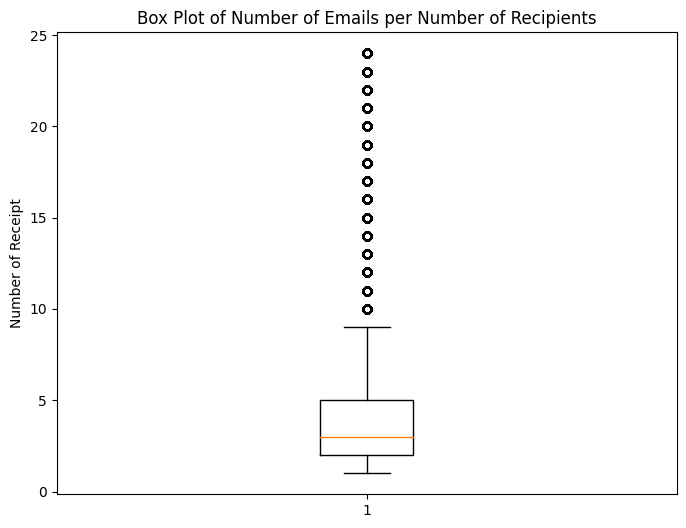

In [ ]:
## DO the box plot with the filtered dataset

message_ids_below_10_df = result_df_dest.filter(result_df_dest["#destinatari_per_email"] < 25)


# Calculate percentiles
percentile_25 = message_ids_below_10_df.approxQuantile("#destinatari_per_email", [0.25], 0.01)[0]
percentile_50 = message_ids_below_10_df.approxQuantile("#destinatari_per_email", [0.50], 0.01)[0]
percentile_75 = message_ids_below_10_df.approxQuantile("#destinatari_per_email", [0.75], 0.01)[0]

# Calculate minimum, maximum, and IQR
min_value = message_ids_below_10_df.select(F.min("#destinatari_per_email")).first()[0]
max_value = message_ids_below_10_df.select(F.max("#destinatari_per_email")).first()[0]
iqr = percentile_75 - percentile_25

# Show statistics
print("Minimo:", min_value)
print("25° percentile:", percentile_25)
print("Mediana (50° percentile):", percentile_50)
print("75° percentile:", percentile_75)
print("Massimo:", max_value)
print("Intervallo interquartile (IQR):", iqr)

# Create a box plot
boxplot_data = message_ids_below_10_df.select("#destinatari_per_email").rdd.flatMap(lambda x: x).collect()
plt.figure(figsize=(8, 6))
plt.boxplot(boxplot_data)
plt.title("Box Plot of Number of Emails per Number of Recipients")
plt.ylabel("Number of Receipt")
plt.show()


In [ ]:
#////////////////////////////// ANALISI ASSUNZIONE SU BUSINESS UNIT SUPERIORE ED INFERIORE: "si scrivono all'interno delle BU" \\\\\\\\\\

# HEATMAP CON I CONTATORI

## questi file vengono procesati nel notebook 3, ma ho deciso di poertare in qeusto nootebook la computazione della heatmap perrché mi sembrava più appropriata
## qeusta è la motivazione per cui il codice non è ottimizzato ed è ripetitivo: ho preso una processo che effettuavo in un passaggio successivo e l'ho protato qui


csv_file_path = '/content/gdrive/MyDrive/processati_email/chunked_userID'
processato=0

# Ottenere le diverse BU_sup con il mapping aggiornato
df_anagrafici_excel = pd.read_excel(io = "/content/gdrive/MyDrive/Colab Notebooks/Dati per POLIMI RIVISTO_OUTPUT.xlsx", engine='openpyxl', sheet_name= 'OUTPUT')
mapping1 = {
        'EBDCFA':'BE',
        'EBDPBK':'BE',
        'EBDRPF':'BE',
        'EUROBA':'BE',

        'EUROFO':'SGR',
        'SGRCCE':'SGR',
        'SGRDBL':'SGR',
        'SGRINV':'SGR',

        'PRIVAT':'CENTRO PRIVATE CREDEM',
        'COPRIV':'CENTRO PRIVATE CREDEM',

        'RP01':'DRC',

        'CSDIR': 'CDMASS',

        'CVDIR': 'CDMVIT',

        'VDGPM':'STAFF DIREZIONE',
        'DIRGEN':'STAFF DIREZIONE',

        'VDGBC':'COMME'
        }
df_anagrafici_excel['UO sup'] = df_anagrafici_excel['UO sup'].replace(mapping1)

bu_sup_unique = df_anagrafici_excel['UO sup'].unique()


# Creare il dataframe vuoto df_bu_email
df_bu_email = pd.DataFrame(index=bu_sup_unique, columns=bu_sup_unique)
df_bu_email.fillna(0, inplace=True)



# Ciclare sugli ID_persona
for filename in os.listdir(csv_file_path):
      if filename.endswith(".csv"):

          # Extract the user_id from the filename by removing the ".csv" extension
          ID_persona = filename[:-4]

          # Read the CSV file into a DataFrame
          csv_file = os.path.join(csv_file_path, filename)
          df_email_completo = pd.read_csv(csv_file)

          processato= processato+1
          if processato%100==0 : print(processato)
          if ((ID_persona=='External') or  (ID_persona=='Consulenti') or  (ID_persona=='ND')or  (ID_persona=='Group')): continue


          # Filtrare le email inviate da ID_persona
          email_inviate = df_email_completo[df_email_completo['source_from_header_address'] == ID_persona]
          bu_mittente = df_anagrafici_excel.loc[df_anagrafici_excel['CODICI RISPONDENTI'] == ID_persona, 'UO sup'].values[0] if len(df_anagrafici_excel[df_anagrafici_excel['CODICI RISPONDENTI'] == ID_persona])>0 else None


          # Ciclare sui destinatari delle email inviate
          for destinatario in email_inviate['destination_address']:
              # Ottenere le BU_sup del mittente e del destinatario
              bu_destinatario = df_anagrafici_excel.loc[df_anagrafici_excel['CODICI RISPONDENTI'] == destinatario, 'UO sup'].values[0] if len(df_anagrafici_excel[df_anagrafici_excel['CODICI RISPONDENTI'] == destinatario])>0 else None

              if (bu_mittente is None) or (bu_destinatario is None): continue

              # Incrementare di 1 la cella corrispondente nel dataframe df_bu_email
              df_bu_email.loc[bu_mittente, bu_destinatario] += 1


100
200


<ipython-input-9-28a439cd0f1e>:59: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_email_completo = pd.read_csv(csv_file)


300
400
500
600
700
800
900
1000
1100
1200
1300


<ipython-input-9-28a439cd0f1e>:59: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_email_completo = pd.read_csv(csv_file)


1400
1500
1600
1700
1800
1900
2000


FileNotFoundError: ignored

No None values found in the DataFrame.


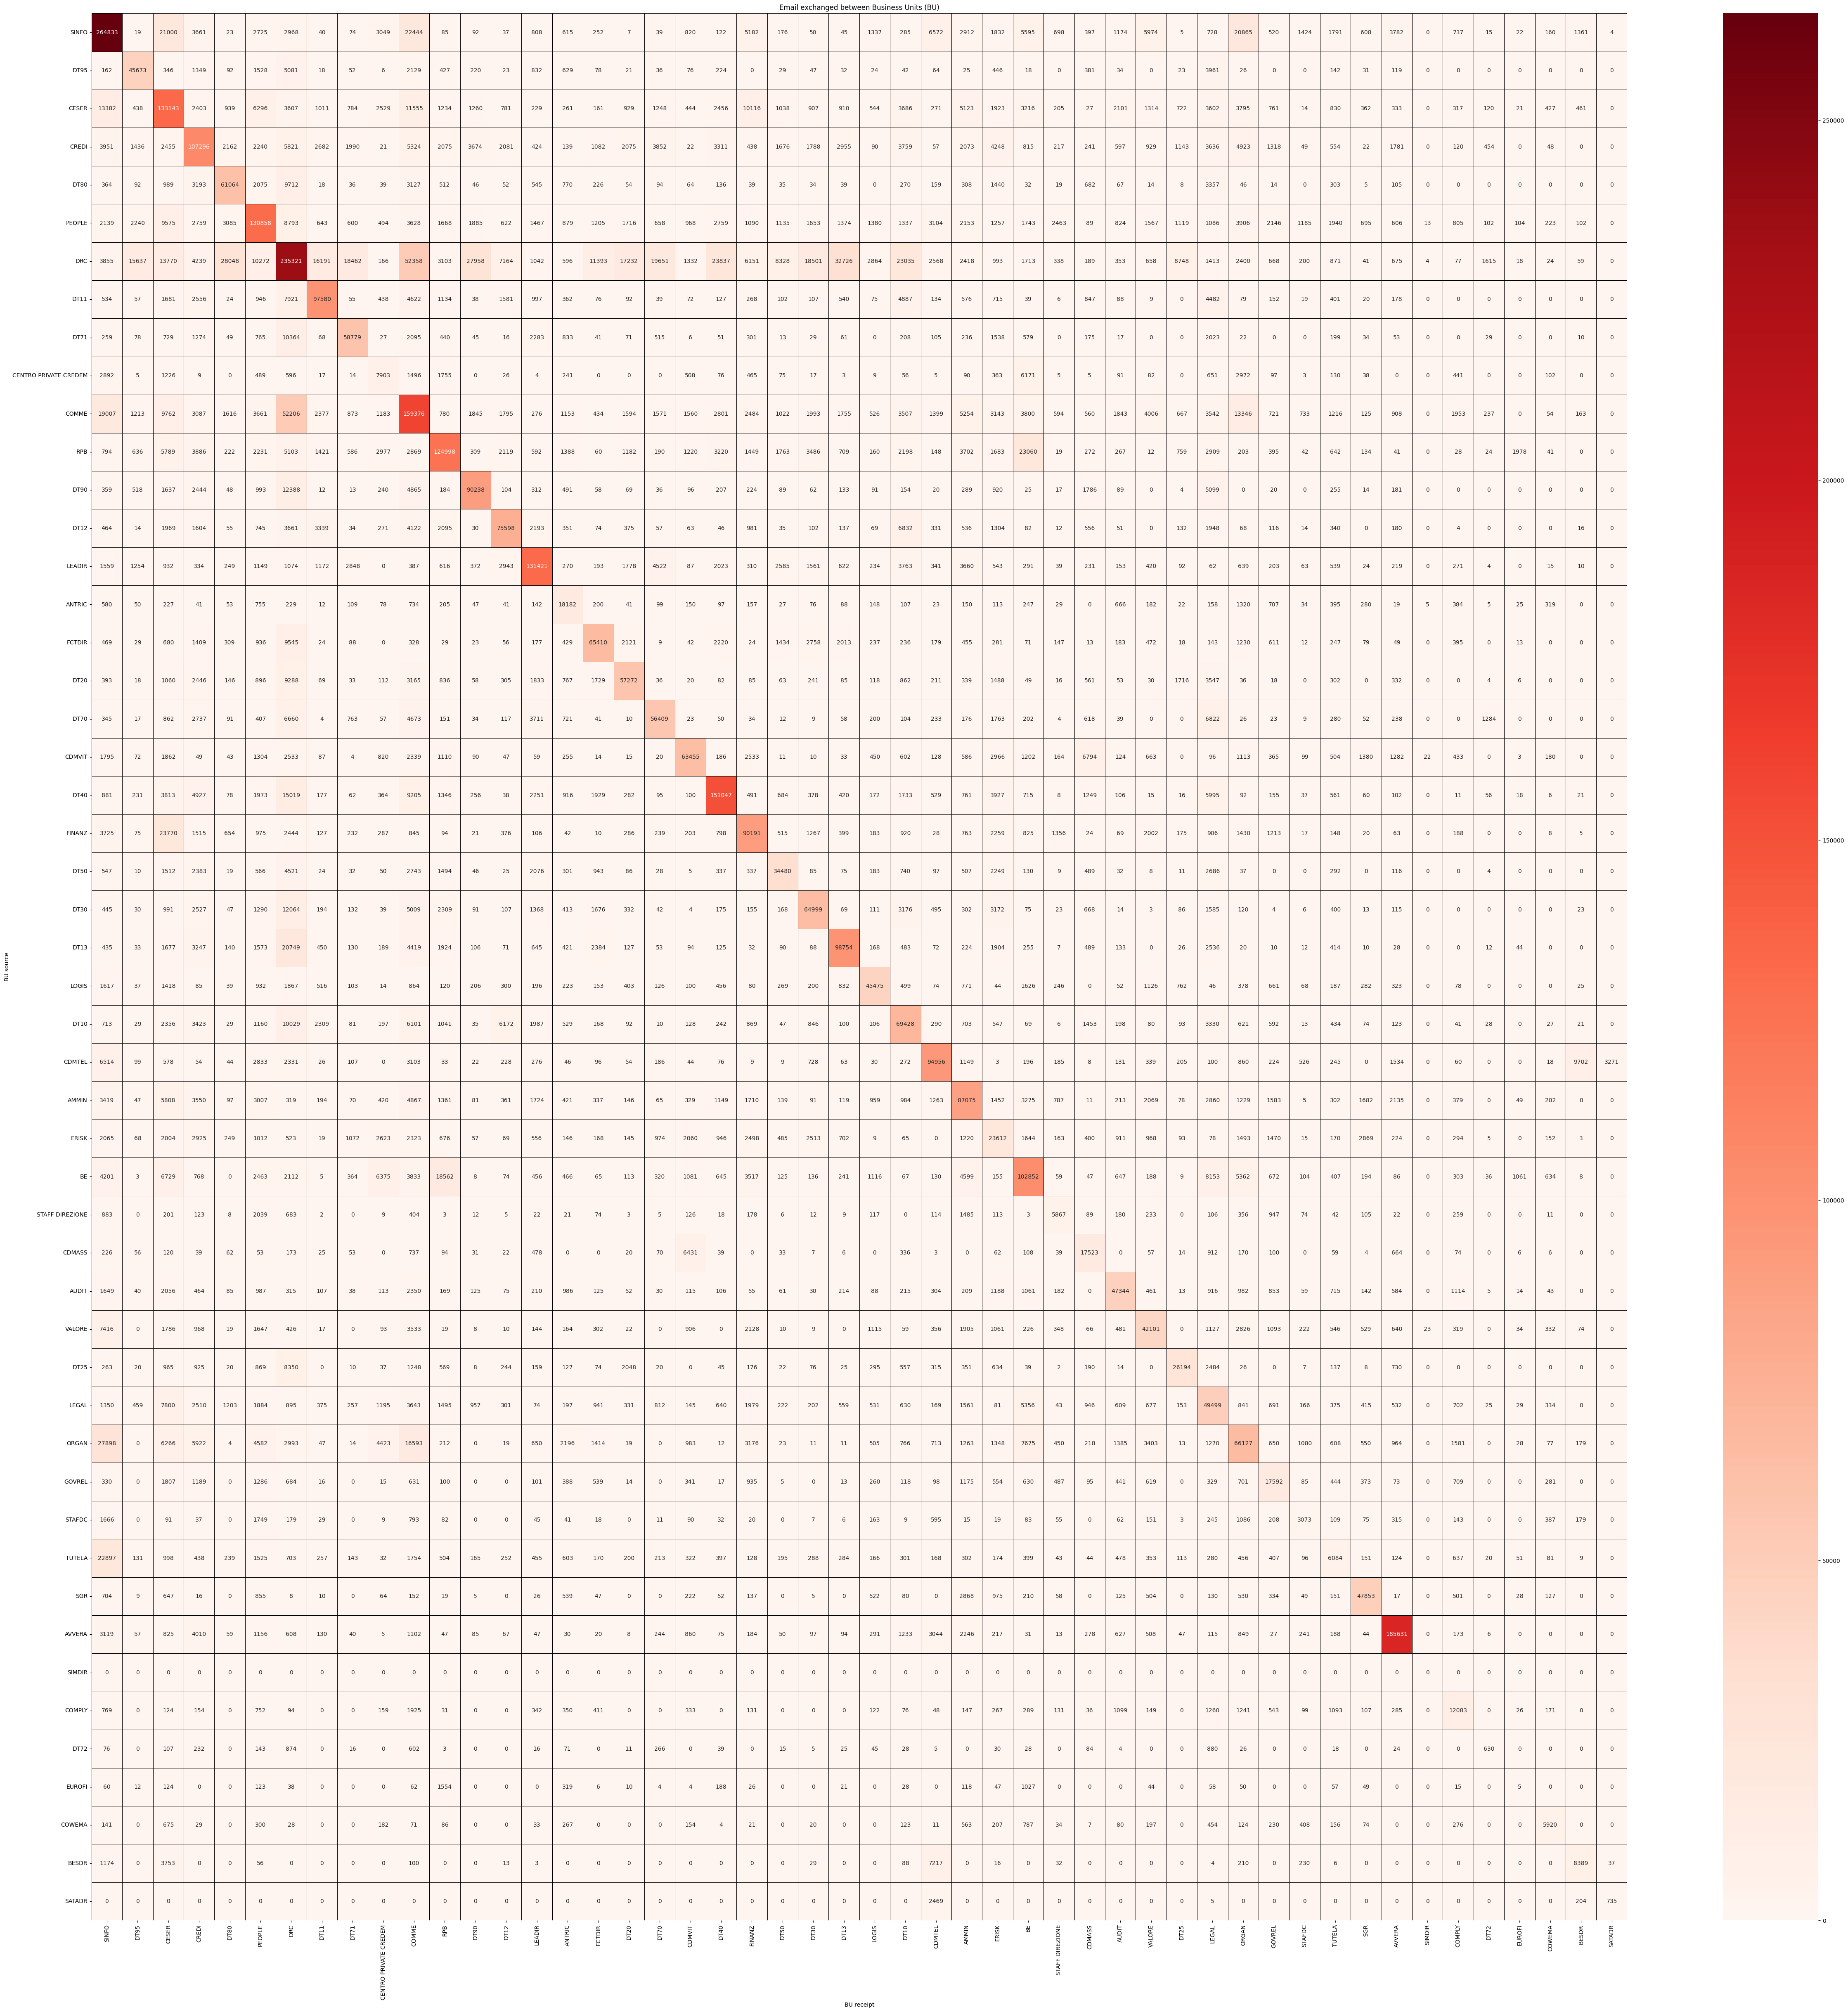

In [ ]:
#////////////////////////////// ANALISI ASSUNZIONE SU BUSINESS UNIT SUPERIORE ED INFERIORE \\\\\\\\\\


if df_bu_email.isnull().values.any():
    # Drop columns with None values
    df_bu_email.dropna(axis=1, inplace=True)

    # Drop rows with None values
    df_bu_email.dropna(axis=0, inplace=True)
else:
    print("No None values found in the DataFrame.")


# HEATMAP

# Trovare il massimo valore di email scambiate tra due Business Unit
max_value = df_bu_email.values.max()

# Creare la heatmap utilizzando seaborn
plt.figure(figsize=(60, 60))
sns.heatmap(df_bu_email, cmap='Reds', annot=True, fmt=".0f", linewidths=0.5, linecolor="black", cbar=True, vmax=max_value)
plt.title("Email exchanged between Business Units (BU)")
plt.xlabel("BU receipt")
plt.ylabel("BU source")
plt.show()


